In [58]:
import json
import datetime

data = json.load(open('user_project_times.json'))

In [59]:
def convert_time(el):
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

In [60]:
# make one sweep through data to get global upper and lower bounds of creation times
earliest = 1e100
latest = 0
for user in data:
    for ctime, _ in data[user]: #ignore last-modified for now
        if ctime < earliest:
            earliest = ctime
        if ctime > latest:
            latest = ctime

print 'Earliest:', convert_time(earliest) 
print 'Latest:', convert_time(latest)

Earliest: 2013-03-27
Latest: 2016-03-10


For exploratory analysis, let's divide this interval into days, and count the number of projects created each day

In [61]:
days = (latest-earliest)/(86400.*1000)
print days, 'in timespan'

import numpy
project_counts = numpy.zeros(int(days+1))

1079.18398146 in timespan


In [62]:
for user in data:
    for ctime, _ in data[user]: 
        cday = int((ctime-earliest)/(86400.*1000))
        project_counts[cday] += 1

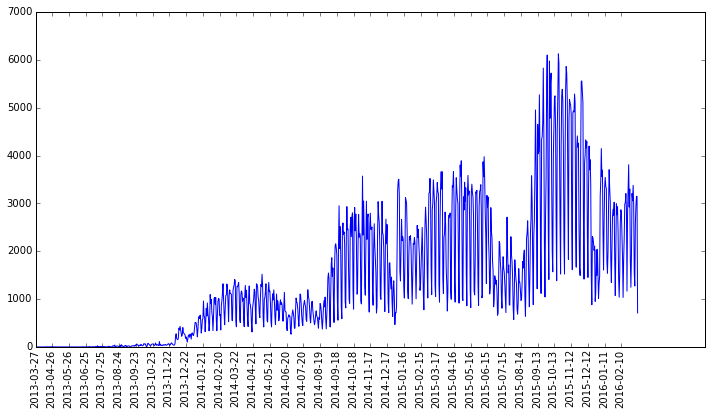

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = (12, 6)

def time_plot(arr):
    plt.plot(range(arr.size), arr)
    xtoshow = range(0, arr.size, 30)
    plt.xticks(xtoshow, [str(convert_time(x*86400*1000 + earliest)) for x in xtoshow], rotation=90)
    plt.show()
    
time_plot(project_counts)

We see distinct bursts in the Fall and Spring semesters.

Let's look at the number of distinct users on each day.

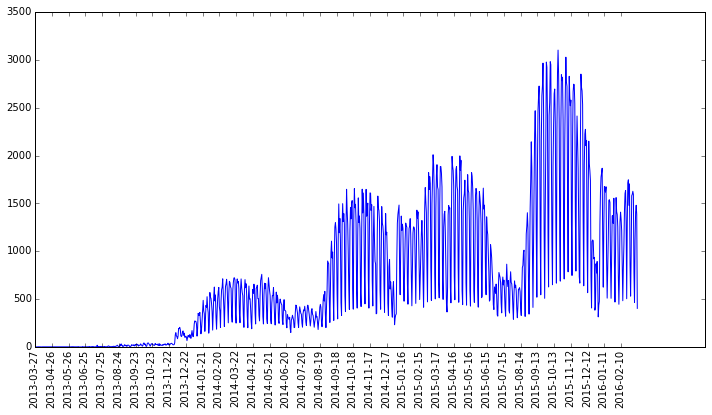

In [64]:
user_counts = numpy.zeros(int(days+1))
for user in data:
    thisuser_counts = numpy.zeros(int(days+1))
    for ctime, _ in data[user]: 
        cday = int((ctime-earliest)/(86400.*1000))
        thisuser_counts[cday] = 1
    user_counts += thisuser_counts
    
time_plot(user_counts)

Not too different.

Now let's get the length of activity for each user (still using creation times) in days. 

In [65]:
users = data.keys()
activity_length_hist = numpy.zeros(len(users))
for i, user in enumerate(users):
    ctimes = [ctime for ctime, _ in data[user]]
    user_activity_length[i] = (max(ctimes) - min(ctimes))/(86400*1000)

The histogram shows the number of users whose activity time was within `x` number of days.

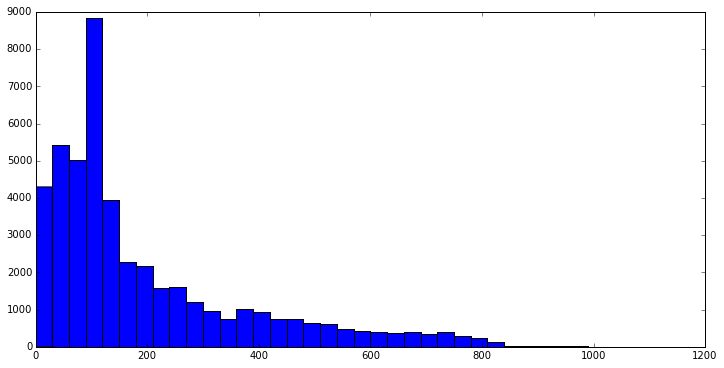

In [66]:
plt.hist(user_activity_length, bins=range(0, int(max(user_activity_length))+1, 30))
plt.show()

Seems like the majority of users are active for less than 120 days, which is about the length of a semester. Modal user activity is 90-120 days, which is about the length of a semester.

**Question:** what predicts whether a user will stay on beyond, say, 120 days, using the first 120 days of activity?

Features: Number of projects created at 10% (12-day) intervals, or similar.

*Attempt 1*

Cluster all users based on their activities in their first 120 days according to these features. 
Do "retained" users cluster together? 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction import DictVectorizer

def featurize(user):
    """return a dictionary mapping each feature name to a feature value 
    for a particular user represented as list of (creation times, modified times),
    using only their first 120 days of activity"""
    #note: feature names are for our reference only
    
users_featdicts = map(featurize, data.values())

vec = DictVectorizer()
X = vec.fit_transform(users_featdict) # converts to array: http://scikit-learn.org/stable/modules/feature_extraction.html

model = KMeans(n_clusters=2)
users_clusterids = model.fit_predict(X)

Is there any correlation between the cluster IDs and whether or not a user is active > 120 days?

In [ ]:
from scipy.stats import chi2_contingency
conting = numpy.zeros((2, 2))  # row = cluster ID (0, 1), col = #days (0 for <=120, 1 for >120)

for i in range(len(users)):
    cluster = users_clusterids[i]
    if user_activity_length[i]<=120:
        conting[cluster, 0] += 1
    else:
        conting[cluster, 1] += 1

# visualize
print conting

# compute chi2 statistic to get the probability that there is no association between
# the clustering and whether or not the user is active for >120 days
# lower probabilities are better
_, p, _, _ = chi2_contingency(conting)
print 'There is a', p, 'probability that the clusters and retention are independent.'

Write other feature functions -- perhaps different interval sizes (instead of 10%), proportion of projects rather than number, etc. With some effort, we can get a measure of activity on weekends/evenings as features too. Experiment and be creative.

Give each feature function a distinct name, and re-run the above two cells with the function in place of `featurize` to see if the contingency tables change

Remember from the CS111 assignment that we can combine a list of feature functions to give a new feature function, so you should experiment with combinations as well.

In [ ]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined